<a href="https://colab.research.google.com/github/Bovi-analytics/hut-et-al-2021/blob/master/LegActivity_MonthsInMilk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical notebook for leg activity MonthsInMilk

## Importing of google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## R loading

In [ ]:
%reload_ext rpy2.ipython

In [ ]:
%%R
lib_loc <- "/content/drive/Shareddrives/Bovi-Analytics/R-lib/"

In [ ]:
%%R
package_list <- c("ggplot2",
                  "readr",
                  "plyr",
                  "dplyr",
                  "tidyr",                
                  "lme4",
                  "lmerTest",
                  "multcompView",
                  "mvtnorm",
                  "TH.data",
                  "multcomp",
                  "emmeans",
                  "lsmeans",
                  "carData",
                  "car"
                  )

for (pkg in package_list) {
  if (pkg %in% rownames(.packages()) == FALSE)
  {library(pkg, lib.loc = lib_loc, character.only = TRUE)}

}

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step


R[write to console]: Loading required package: survival

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching

## Data loading into dataframe

In [ ]:
%%R
url = ('/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/ObservationType=LegActivityStepsPerDay/part-00000-tid-183333261268000902-29b42dfd-564e-4e7d-8ea7-05b4fb30d5d6-1694-15.c000.csv')

dataset = read.csv(url)



In [ ]:
%%R

#path <- "/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/ObservationType=LegActivityStepsPer2Hours/part-00000-tid-183333261268000902-29b42dfd-564e-4e7d-8ea7-05b4fb30d5d6-1694-13.c000.csv"
AnalysisData <- 
  readr::read_csv("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/ObservationType=LegActivityStepsPerDay/part-00000-tid-183333261268000902-29b42dfd-564e-4e7d-8ea7-05b4fb30d5d6-1694-15.c000.csv", 
    col_types = readr::cols(HerdIdentifier = readr::col_character(), 
        TransitionLactationNumber = readr::col_integer(), 
        TransitionParity = readr::col_character(), 
        TransitionMonthsInMilk = readr::col_integer(), 
        TransitionCalvingDate = readr::col_character(), 
        Hour = readr::col_integer(), 
        Observations = readr::col_integer())) %>% 
  dplyr::filter(dplyr::between(TransitionMonthsInMilk, -1, 10)) %>%
  dplyr::mutate(
    AnimalIdentifier = factor(AnimalIdentifier),
    HerdIdentifier = factor(HerdIdentifier),
    Parity = factor(TransitionParity),
    MonthsInMilk = factor(TransitionMonthsInMilk),
    CalvingSeason = factor(TransitionSeason),
    Hour = factor(Hour),
    SensorValue = ObservationValue,
    MilkingType = factor(case_when(
    HerdIdentifier %in% c("544", "2514", "3314")~"AMS",
    TRUE~"CMS"
  ))
  ) %>%
  dplyr::select(AnimalIdentifier, HerdIdentifier, Parity, MonthsInMilk, CalvingSeason, Hour, SensorValue, MilkingType) %>%
  tidyr::drop_na()

In [ ]:
%%R
head(AnalysisData)

# A tibble: 6 x 8
  AnimalIdentifier HerdIdentifier Parity MonthsInMilk CalvingSeason Hour 
  <fct>            <fct>          <fct>  <fct>        <fct>         <fct>
1 33               2746           2      -1           Summer        22   
2 644              2514           3+     6            Autumn        23   
3 1092             2514           2      1            Winter        23   
4 55               2746           1      9            Winter        22   
5 46               544            2      8            Autumn        22   
6 163              3              2      4            Autumn        23   
# … with 2 more variables: SensorValue <dbl>, MilkingType <fct>


In [ ]:
%%R
str(AnalysisData)

tibble[,8] [50,188 × 8] (S3: tbl_df/tbl/data.frame)
 $ AnimalIdentifier: Factor w/ 1062 levels "1","2","3","4",..: 33 279 462 55 46 163 285 285 419 45 ...
 $ HerdIdentifier  : Factor w/ 8 levels "2011","2297",..: 4 3 3 4 7 5 3 3 8 4 ...
 $ Parity          : Factor w/ 3 levels "1","2","3+": 2 3 2 1 2 2 2 3 3 3 ...
 $ MonthsInMilk    : Factor w/ 12 levels "-1","0","1","2",..: 1 8 3 11 10 6 9 5 10 2 ...
 $ CalvingSeason   : Factor w/ 4 levels "Autumn","Spring",..: 3 1 4 4 1 1 3 3 3 2 ...
 $ Hour            : Factor w/ 2 levels "22","23": 1 2 2 1 1 2 2 1 2 2 ...
 $ SensorValue     : num [1:50188] 6896 3235 3289 4035 2616 ...
 $ MilkingType     : Factor w/ 2 levels "AMS","CMS": 2 1 1 2 1 2 1 1 2 2 ...


## Descriptive statistics

In [ ]:
%%R
AnalysisData %>%
  group_by(Parity) %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 3 x 2
  Parity Unique_Elements
  <fct>            <int>
1 1                  709
2 2                  699
3 3+                 745


In [ ]:
%%R
AnalysisData %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 1 x 1
  Unique_Elements
            <int>
1            1062


# Model building

First we determine the null model

## Null model

In [ ]:
%%R
Model.0 <- lme4::lmer(
                  SensorValue ~ 1 + (1| HerdIdentifier:AnimalIdentifier), 
                  data = AnalysisData
                  )


## Univariable models

In [ ]:
%%R
Model1.0 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model.0,Model1.0,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.0: SensorValue ~ MonthsInMilk + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 872346 872372 -436170   872340                         
Model1.0   14 871092 871216 -435532   871064 1275.2 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.1 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.1,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.1: SensorValue ~ Parity + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance Chisq Df Pr(>Chisq)    
Model.0     3 872346 872372 -436170   872340                        
Model1.1    5 871153 871197 -435571   871143  1197  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.2 <- lme4::lmer(
                  SensorValue ~ 
                  CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.2,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.2: SensorValue ~ CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)
Model.0     3 872346 872372 -436170   872340                     
Model1.2    6 872346 872399 -436167   872334 5.8148  3      0.121


In [ ]:
%%R
Model1.3 <- lme4::lmer(
                  SensorValue ~ 
                  MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.3,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.3: SensorValue ~ MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 872346 872372 -436170   872340                         
Model1.3    4 871586 871621 -435789   871578 761.62  1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multivariable models

In [ ]:
%%R
Model2.0 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + MonthsInMilk + CalvingSeason + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )

In [ ]:
%%R
drop1(Model2.0,test="Chisq")

Single term deletions

Model:
SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
    (1 | HerdIdentifier:AnimalIdentifier)
              npar    AIC     LRT Pr(Chi)    
<none>             869190                    
Parity           2 870337 1150.58  <2e-16 ***
MonthsInMilk    11 870372 1203.40  <2e-16 ***
CalvingSeason    3 869185    1.07  0.7834    
MilkingType      1 869970  781.82  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Introduction of interactions

### Interactions with MonthsInMilk

In [ ]:
%%R
Model2.1 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + CalvingSeason + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.1,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.1: SensorValue ~ MonthsInMilk * Parity + CalvingSeason + MilkingType + 
Model2.1:     (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   20 869190 869367 -434575   869150                         
Model2.1   42 868855 869226 -434386   868771 379.01 22  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.2 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*MilkingType + CalvingSeason + Parity +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.2,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.2: SensorValue ~ MonthsInMilk * MilkingType + CalvingSeason + Parity + 
Model2.2:     (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance Chisq Df Pr(>Chisq)    
Model2.0   20 869190 869367 -434575   869150                        
Model2.2   31 868995 869268 -434466   868933 217.8 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.3 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + Parity + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.3,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.3: SensorValue ~ MonthsInMilk * CalvingSeason + Parity + MilkingType + 
Model2.3:     (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance Chisq Df Pr(>Chisq)    
Model2.0   20 869190 869367 -434575   869150                        
Model2.3   53 855310 855777 -427602   855204 13947 33  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multiple interactions

In [ ]:
%%R
Model2.4 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*Parity + 
                  MonthsInMilk*MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.4,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.4: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity + 
Model2.4:     MonthsInMilk * MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance Chisq Df Pr(>Chisq)    
Model2.0   20 869190 869367 -434575   869150                        
Model2.4   86 854680 855439 -427254   854508 14642 66  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
summary(Model2.4)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity +  
    MonthsInMilk * MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
   Data: AnalysisData

      AIC       BIC    logLik  deviance  df.resid 
 854680.1  855439.0 -427254.1  854508.1     50102 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.1066 -0.6059 -0.1094  0.4713 12.0131 

Random effects:
 Groups                          Name        Variance Std.Dev.
 HerdIdentifier:AnimalIdentifier (Intercept)  413823   643.3  
 Residual                                    1349823  1161.8  
Number of obs: 50188, groups:  HerdIdentifier:AnimalIdentifier, 1702

Fixed effects:
                                   Estimate Std. Error t value
(Intercept)                         3556.77      71.28  49.901
MonthsInMilk0                        471.51      83.08   5.675
MonthsInMilk1                        528.72      85.34   6.195
MonthsInMilk2        

R[write to console]: 
Correlation matrix not shown by default, as p = 84 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [ ]:
%%R
finalModel <- Model2.4
Modeldrop <- drop1(finalModel, test="Chisq")
if("Pr(>F)" %in% colnames(Modeldrop))
{
  Pvalues <- Modeldrop$`Pr(>F)`
} else 
{
  Pvalues <- Modeldrop$`Pr(Chi)`
}
Modeldrop

Single term deletions

Model:
SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity + 
    MonthsInMilk * MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
                           npar    AIC     LRT   Pr(Chi)    
<none>                          854680                      
MonthsInMilk:CalvingSeason   33 868661 14047.2 < 2.2e-16 ***
MonthsInMilk:Parity          22 855163   527.0 < 2.2e-16 ***
MonthsInMilk:MilkingType     11 854829   171.2 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
save(finalModel, file="/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/finalmodellegactivity.rdata")

# Final model analysis of variance

In [ ]:
%%R
Anova(finalModel)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: SensorValue
                                Chisq Df Pr(>Chisq)    
MonthsInMilk                1642.7086 11     <2e-16 ***
CalvingSeason                  1.5292  3     0.6756    
Parity                      1844.3295  2     <2e-16 ***
MilkingType                  943.7497  1     <2e-16 ***
MonthsInMilk:CalvingSeason 16272.0621 33     <2e-16 ***
MonthsInMilk:Parity          529.9491 22     <2e-16 ***
MonthsInMilk:MilkingType     171.5349 11     <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Final model figures and LSM (95% CI)

## Main effects

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MonthsInMilk), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 50188' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 50188)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 50188' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 50188)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group    
 -1             3206 29.0 Inf      3123      3289  a        
 0              3547 26.5 Inf      3471      3623   b       
 10             3557 27.0 Inf      3480      3634   b       
 9              3614 26.9 Inf      3537      3691   bc      
 7              3674 26.8 Inf      3597      3750    cd     
 8              3717 26.7 Inf      3640      3793     d     
 6              3745 26.8 Inf      3668      3822     de    
 4              3824 26.9 Inf      3747      3901      ef   
 5              3866 26.9 Inf      3789      3943       fg  
 3              3922 27.1 Inf      3845      4000        g  
 2              4131 27.3 Inf      4053      4209         h 
 1              4247 27.6 Inf      4168      4325          i

Results are averaged over the levels of: CalvingSeason, Parity, MilkingType 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 12 estimates 
P value

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Parity), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 50188' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 50188)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 50188' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 50188)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 Parity lsmean   SE  df asymp.LCL asymp.UCL .group
 3+       3427 19.7 Inf      3380      3474  a    
 2        3705 20.7 Inf      3655      3754   b   
 1        4130 21.1 Inf      4080      4181    c  

Results are averaged over the levels of: MonthsInMilk, CalvingSeason, MilkingType 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 3 estimates 
P value adjustment: tukey method for comparing a family of 3 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ CalvingSeason), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 50188' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 50188)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 50188' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 50188)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 CalvingSeason lsmean   SE  df asymp.LCL asymp.UCL .group
 Summer          3690 22.1 Inf      3635      3745  a    
 Autumn          3761 22.1 Inf      3706      3816   b   
 Spring          3778 23.3 Inf      3720      3836   b   
 Winter          3787 23.3 Inf      3729      3845   b   

Results are averaged over the levels of: MonthsInMilk, Parity, MilkingType 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 4 estimates 
P value adjustment: tukey method for comparing a family of 4 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MilkingType), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 50188' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 50188)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 50188' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 50188)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 MilkingType lsmean   SE  df asymp.LCL asymp.UCL .group
 AMS           3193 30.2 Inf      3125      3260  a    
 CMS           4315 20.5 Inf      4270      4361   b   

Results are averaged over the levels of: MonthsInMilk, CalvingSeason, Parity 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 2 estimates 
significance level used: alpha = 0.05 


## Interactions

### MonthsInMilk by parity

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|Parity, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 50188' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 50188)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 50188' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 50188)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



Parity = 1:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group   
 -1             3212 52.0 Inf      3063      3361  a       
 10             3818 39.8 Inf      3704      3932   b      
 9              3922 40.1 Inf      3807      4037   bc     
 7              3950 40.6 Inf      3834      4066   bc     
 8              4051 40.2 Inf      3936      4166    cd    
 6              4074 41.1 Inf      3957      4191    cde   
 0              4126 42.5 Inf      4004      4247     de   
 4              4158 41.5 Inf      4039      4276     de   
 5              4221 41.0 Inf      4103      4338      ef  
 3              4389 42.0 Inf      4269      4509       f  
 2              4696 42.8 Inf      4574      4818        g 
 1              4947 44.2 Inf      4821      5073         h

Parity = 2:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group   
 0              3470 38.6 Inf      3359      3580  a       
 -1             3476 41.9 Inf      3356      3596  ab      
 10            

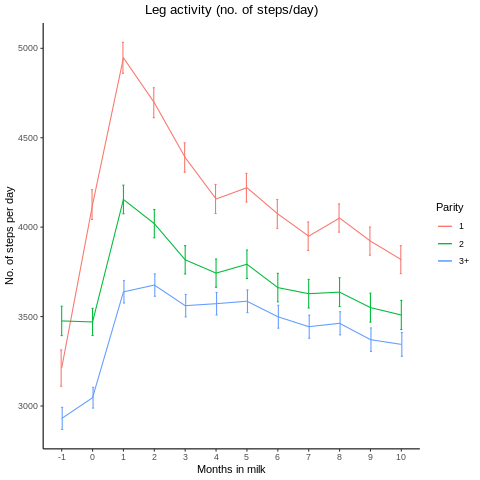

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(Parity), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=Parity, 
    color=Parity)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Leg activity (no. of steps/day)", 
    y="No. of steps per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

###MonthsInMilk by milking type

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|MilkingType, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 50188' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 50188)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 50188' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 50188)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



MilkingType = AMS:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group   
 -1             2776 45.9 Inf      2645      2907  a       
 10             2898 43.6 Inf      2773      3022  ab      
 9              2968 43.5 Inf      2844      3093   bc     
 7              3056 43.6 Inf      2932      3181    cd    
 8              3086 43.4 Inf      2962      3210    cd    
 0              3128 43.2 Inf      3004      3251     d    
 6              3168 43.6 Inf      3043      3293     de   
 5              3308 43.6 Inf      3184      3433      ef  
 4              3313 43.7 Inf      3188      3437      ef  
 3              3380 43.9 Inf      3254      3505       f  
 2              3553 44.5 Inf      3426      3680        g 
 1              3681 44.9 Inf      3552      3809        g 

MilkingType = CMS:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group   
 -1             3636 31.7 Inf      3545      3727  a       
 0              3967 28.5 Inf      3885      4048   b      
 

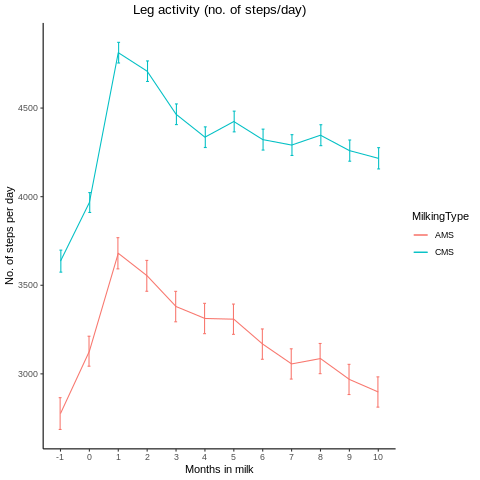

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(MilkingType), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=MilkingType, 
    color=MilkingType)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Leg activity (no. of steps/day)", 
    y="No. of steps per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### MonthsInMilk by calving season

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 50188' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 50188)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 50188' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 50188)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



CalvingSeason = Autumn:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group   
 4              2997 42.9 Inf      2874      3120  a       
 3              3091 42.9 Inf      2968      3214  a       
 5              3159 39.6 Inf      3046      3272  a       
 6              3393 40.2 Inf      3279      3508   b      
 2              3402 38.1 Inf      3293      3511   b      
 7              3741 40.0 Inf      3627      3855    c     
 0              3869 36.0 Inf      3767      3972    cd    
 1              3951 38.3 Inf      3842      4061     d    
 -1             3981 42.1 Inf      3861      4101     d    
 8              4433 44.1 Inf      4307      4559      e   
 10             4513 42.6 Inf      4391      4634      e   
 9              4608 43.8 Inf      4482      4733      e   

CalvingSeason = Spring:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group   
 -1             2488 47.5 Inf      2352      2624  a       
 10             2646 49.7 Inf      2504      2788  

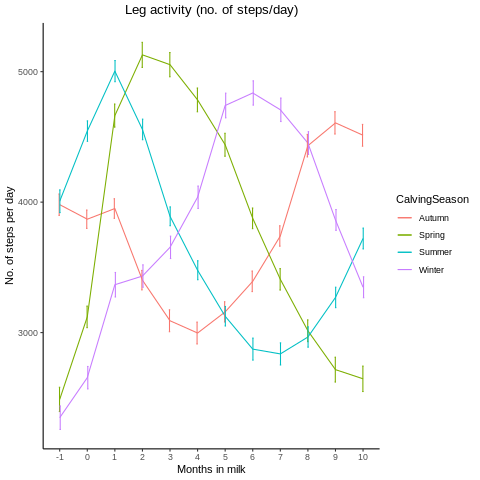

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Leg activity (no. of steps/day)", 
    y="No. of steps per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

In [ ]:
%%R
AnalysisDataAMS <- AnalysisData %>% dplyr::filter(MilkingType == "AMS")
AnalysisDataCMS <- AnalysisData %>% dplyr::filter(MilkingType != "AMS")

In [ ]:
%%R
ModelAMSOnly <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*Parity + 
                   MonthsInMilk*CalvingSeason + 
                    (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisDataAMS
                  )

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(ModelAMSOnly, pairwise ~ MonthsInMilk|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 16040' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 16040)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 16040' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 16040)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



CalvingSeason = Autumn:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group  
 6              2799 50.0 Inf      2657      2942  a      
 7              2829 49.8 Inf      2687      2972  a      
 5              2863 50.1 Inf      2720      3006  ab     
 4              2906 53.7 Inf      2753      3059  ab     
 3              2993 54.2 Inf      2838      3148  abc    
 8              3031 54.6 Inf      2875      3187   bcd   
 2              3169 49.4 Inf      3028      3310    cde  
 9              3233 54.3 Inf      3078      3388     def 
 -1             3262 54.2 Inf      3107      3417      ef 
 10             3326 53.1 Inf      3174      3478      ef 
 0              3413 48.7 Inf      3274      3552       fg
 1              3589 50.7 Inf      3444      3733        g

CalvingSeason = Spring:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group  
 -1             2326 66.0 Inf      2137      2514  a      
 9              2701 61.8 Inf      2525      2878   b     
 10    

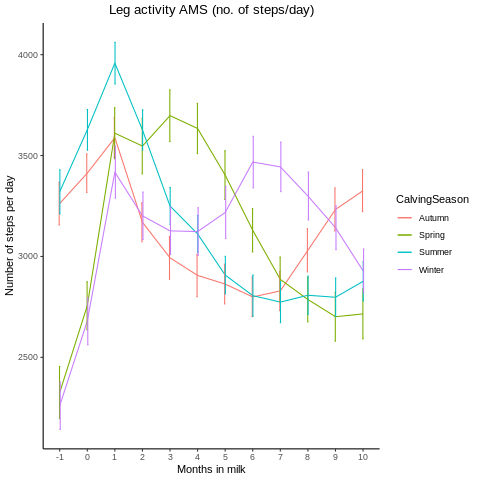

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Leg activity AMS (no. of steps/day)", 
    y="Number of steps per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

In [ ]:
%%R
ModelCMSOnly <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*Parity + 
                   MonthsInMilk*CalvingSeason + 
                    (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisDataCMS
                  )

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(ModelCMSOnly, pairwise ~ MonthsInMilk|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 34148' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 34148)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 34148' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 34148)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



CalvingSeason = Autumn:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group  
 4              3268 55.2 Inf      3111      3426  a      
 3              3385 54.8 Inf      3228      3541  ab     
 5              3564 50.4 Inf      3420      3708   b     
 2              3798 47.4 Inf      3663      3933    c    
 6              3960 51.9 Inf      3812      4109    c    
 0              4294 43.7 Inf      4169      4419     d   
 1              4407 47.3 Inf      4272      4542     de  
 7              4511 51.6 Inf      4364      4659      e  
 -1             4553 52.7 Inf      4403      4704      e  
 10             5449 54.9 Inf      5292      5606       f 
 8              5478 57.1 Inf      5314      5641       f 
 9              5641 56.6 Inf      5479      5803       f 

CalvingSeason = Spring:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group  
 -1             2819 57.0 Inf      2656      2982  a      
 10             2936 63.1 Inf      2756      3117  a      
 9     

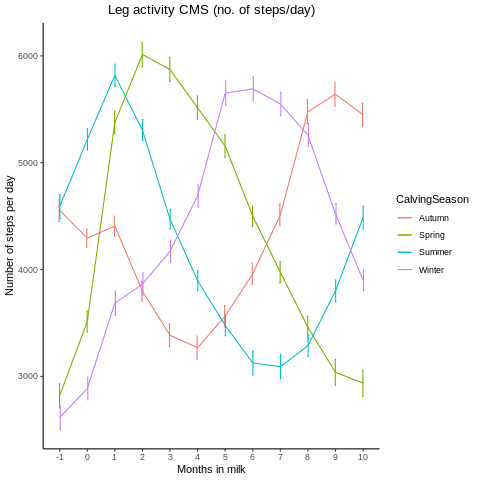

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Leg activity CMS (no. of steps/day)", 
    y="Number of steps per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))